# Crash course on Bayesian hierarchical modeling using PyMC3

In [1]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import pymc3 as pm
import toolz as tz
import itertools
import arviz as az

%matplotlib inline

In [2]:
## Generate data

GROUP_PARAMS = [
    dict(label='A', n=54, x_mean=2, x_sd=0.8, y_int=0, y_slope=1.5, y_sd=1),
    dict(label='B', n=18, x_mean=12, x_sd=1.2, y_int=-7, y_slope=1.0, y_sd=1),
    dict(label='C', n=6, x_mean=8, x_sd=1., y_int=-15, y_slope=1.2, y_sd=1)
]

def points(params):
    keys = ['label', 'n', 'x_mean', 'x_sd', 'y_int', 'y_slope', 'y_sd']
    label, n, x_mean, x_sd, y_int, y_slope, y_sd = tz.get(keys, params)
    x = x_mean + x_sd * np.random.randn(n)
    y = y_int + y_slope * x + y_sd * np.random.randn(n)
    return {'x': x, 'y': y, 'label': label}

def dataframe(group_params):
    return pd.concat([pd.DataFrame(points(p)) for p in group_params], ignore_index=True)

dataframe(GROUP_PARAMS).to_csv('group_sample_data.csv', index=False)

## Load the data

In [3]:
data = pd.read_csv('group_sample_data.csv')
data.head()

x         y label
0  0.702051 -0.473185     A
1  2.560231  1.556026     A
2  2.740272  4.306631     A
3  2.738357  5.003075     A
4  1.664044  2.371450     A

## Show the data

In [4]:
# Plotting stuff

COLORS = ['rgb(251,128,114)', 'rgb(128,177,211)', 'rgb(179,222,105)']
LAYOUT = go.Layout(
    width=800, height=800,
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    plot_bgcolor='white'
)

def group_scatter(group, label, color):
    return go.Scatter(
        x=group['x'], y=group['y'],
        name=label,
        mode='markers',
        marker=dict(size=8, color=color)
    )

def all_scatters(data, colors):
    colors_cycle = itertools.cycle(colors)
    return [
        group_scatter(g, l, next(colors_cycle))
        for l, g in data.groupby('label')
    ]

def line_points(xmin, xmax, intercept, slope):
    ymin, ymax = (
        intercept + slope * xmin, 
        intercept + slope * xmax
    )
    return np.array([xmin, xmax]), np.array([ymin, ymax]).T

def line_trace(x, y, color):
    return go.Scatter(
        x=x, y=y,
        mode='lines',
        opacity=0.2,
        line=dict(
            width=1,
            color=color
        ),
        showlegend=False
    )


def all_lines(xmin, xmax, intercept, slope, color='rgb(180,180,180)'):
    x, ys = line_points(xmin, xmax, intercept, slope)
    return [line_trace(x, y, color) for y in ys]

def group_lines(trace, data, colors=COLORS):
    int_a, int_b, int_c = trace['intercept'].T
    slp_a, slp_b, slp_c = trace['slope'].T
    (xa_min, xa_max), (xb_min, xb_max), (xc_min, xc_max) = data.groupby('label')['x'].agg(['min', 'max']).values
    lines_a = all_lines(xa_min, xa_max, int_a[::10], slp_a[::10], color=colors[0])
    lines_b = all_lines(xb_min, xb_max, int_b[::10], slp_b[::10], color=colors[1])
    lines_c = all_lines(xc_min, xc_max, int_c[::10], slp_c[::10], color=colors[2])
    return lines_a + lines_b + lines_c

def figure(traces, layout=LAYOUT):
    return go.Figure(data=traces, layout=layout)

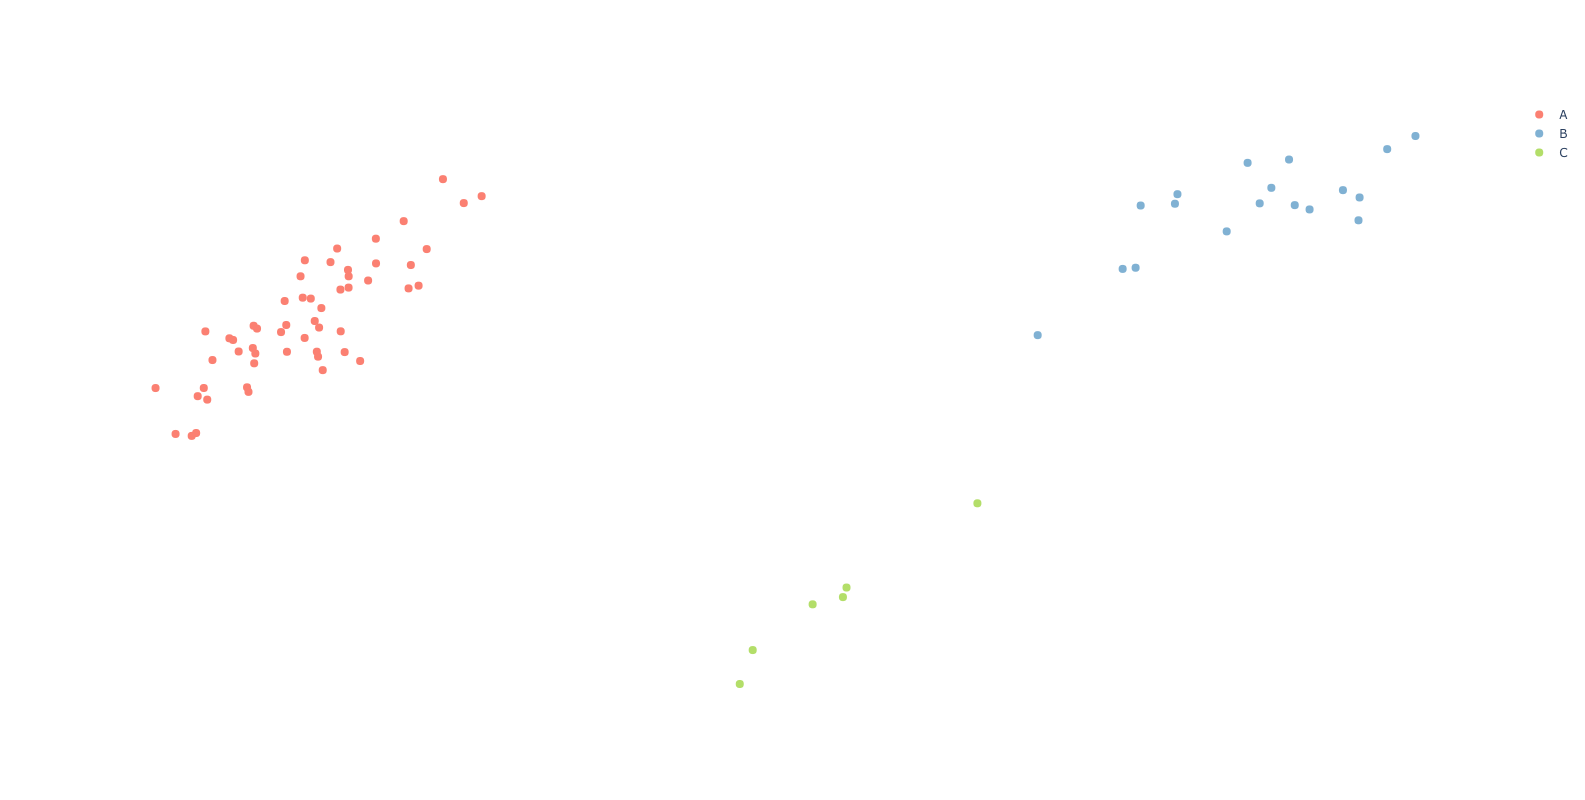

In [5]:
f = figure(all_scatters(data, COLORS))
f.show()

## A bad model (completely pooled)

In [6]:
with pm.Model() as model_cp:
    intercept = pm.Normal('intercept', mu=data['y'].mean(), sigma=10)
    slope = pm.Normal('slope', mu=0, sigma=1)
    mu = pm.Deterministic('mu_y', intercept + slope * data['x'].values)
    sigma = pm.HalfNormal('sigma_y', sigma=10)
    pm.Normal('y', mu=mu, sigma=sigma, observed=data['y'].values)

## Viz the model

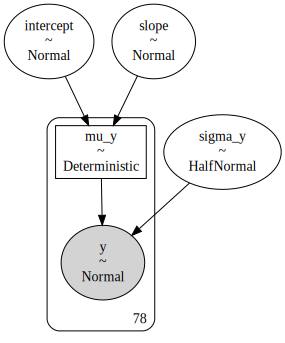

In [7]:
pm.model_to_graphviz(model_cp)

## Sample the posterior

In [8]:
with model_cp:
    trace_cp = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_y, slope, intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.


## Diagnose the trace

/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



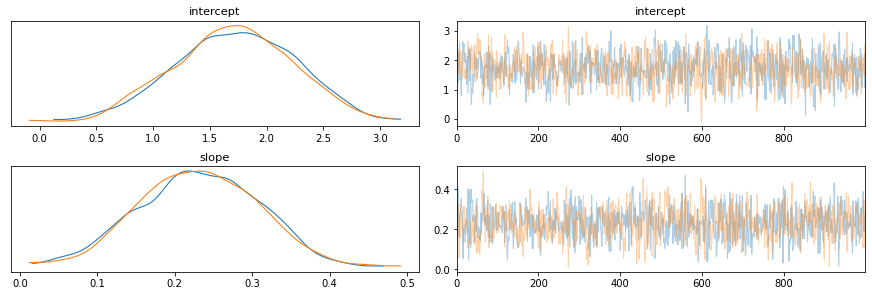

In [9]:
az.plot_trace(trace_cp, var_names=['intercept', 'slope']);

## Plot the posterior

/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



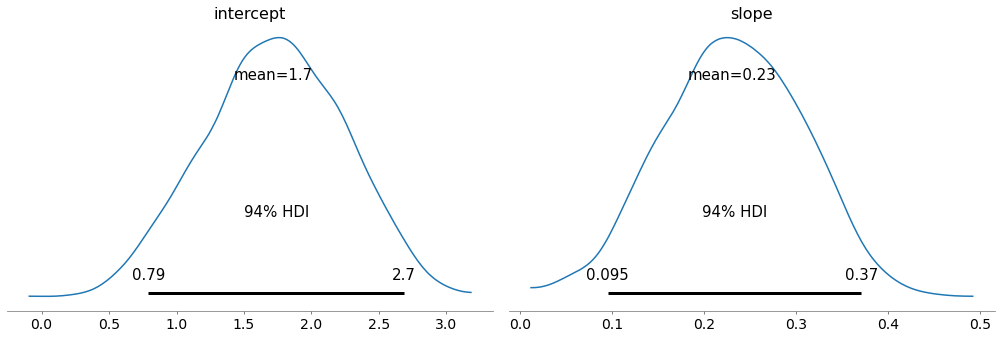

In [10]:
az.plot_posterior(trace_cp, var_names=['intercept', 'slope']);

## Viz the posterior

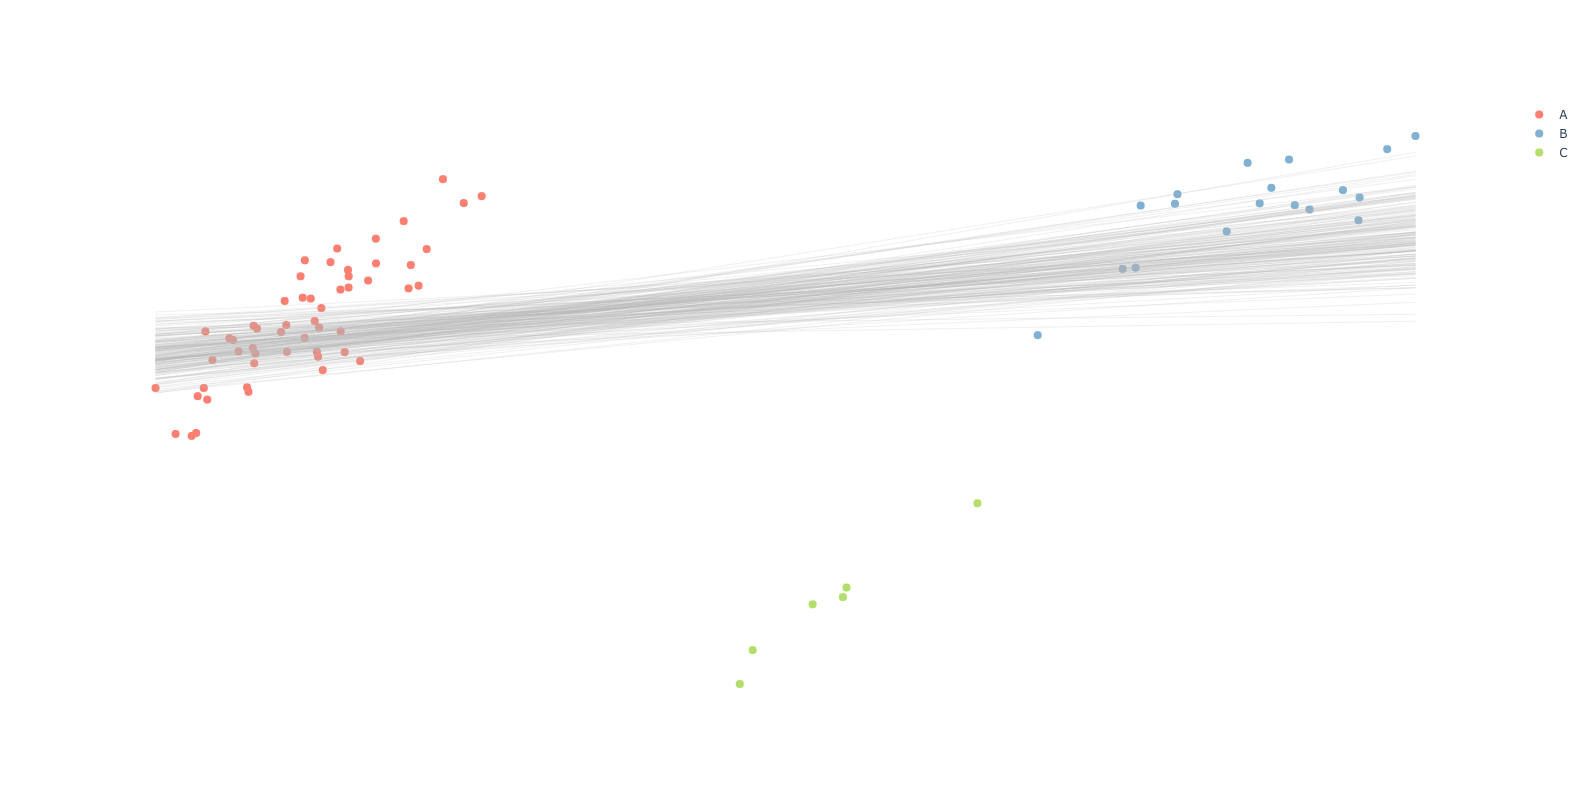

In [11]:
lines = all_lines(data['x'].min(), data['x'].max(), trace_cp['intercept'][::10], trace_cp['slope'][::10])
traces = all_scatters(data, COLORS) + lines
fig = figure(traces)
fig.show()

## Separately model each group (unpooled)

In [12]:
with pm.Model() as model_up:
    
    intercept = pm.Normal('intercept', mu=0, sigma=10, shape=3)
    slope = pm.Normal('slope', mu=0, sigma=1, shape=3)
    
    sigma = pm.HalfNormal('sigma', sigma=5, shape=3)
    
    for i, (label, group) in enumerate(data.groupby('label')):
        mu = intercept[i] + slope[i] * group['x'].values
        pm.Normal(f'y_{label}', mu=mu, sigma=sigma[i], observed=group['y'].values)

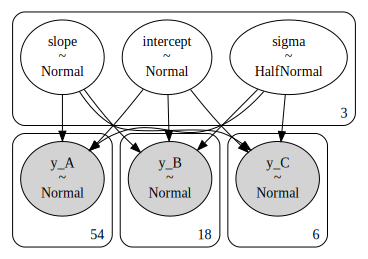

In [13]:
pm.model_to_graphviz(model_up)

In [14]:
with model_up:
    trace_up = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, slope, intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
There were 361 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5862865762792987, but should be close to 0.8. Try to increase the number of tuning steps.
There were 418 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.47660967851036057, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



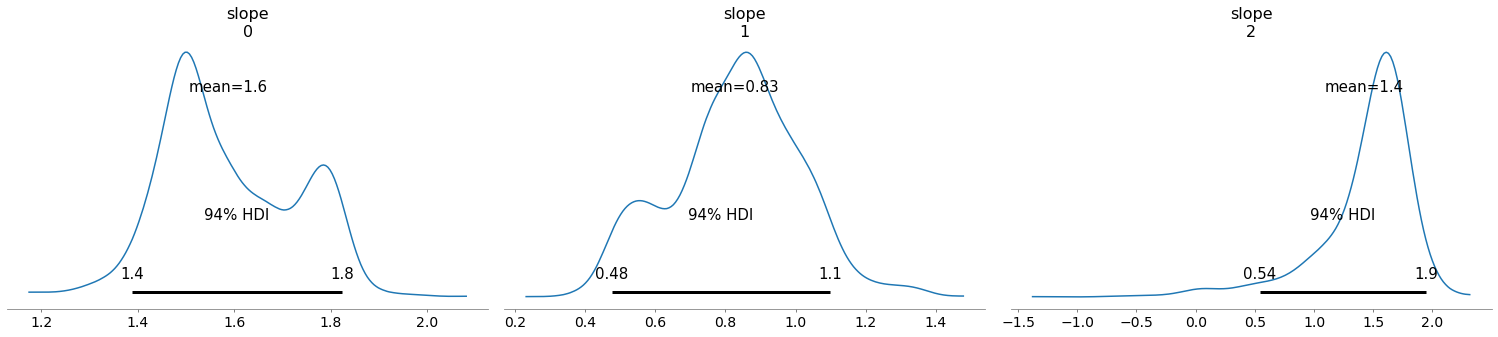

In [15]:
az.plot_posterior(trace_up, var_names=['slope']);

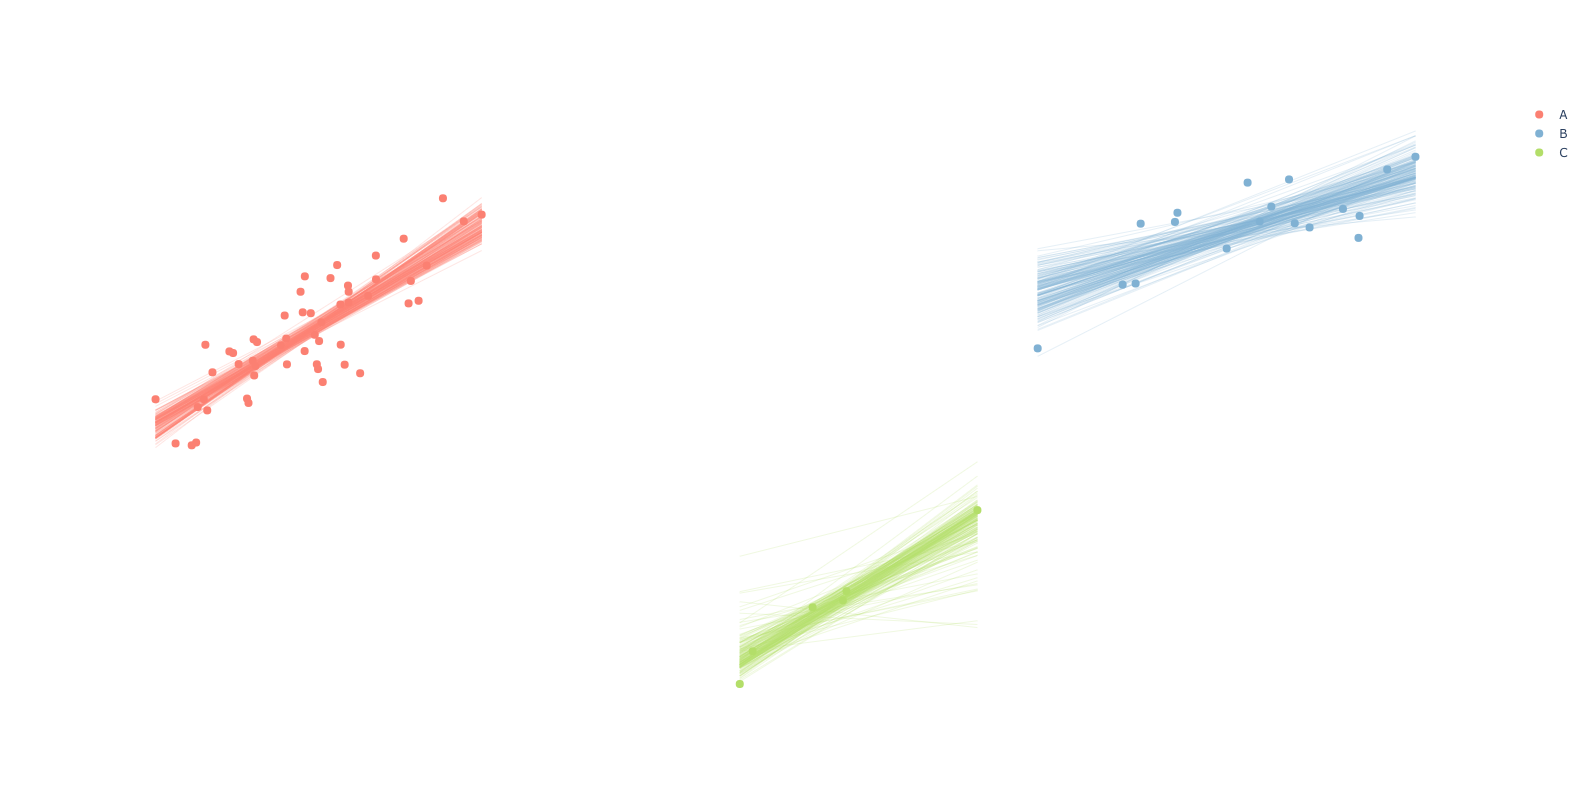

In [16]:
fig = figure(all_scatters(data, COLORS) + group_lines(trace_up, data))
fig.show()

## Sharing is caring (partially pooled) 

In [17]:
with pm.Model() as model_pp:
    
    # A shared slope hyperparameter
    mu_slope = pm.Normal('mu_slope', mu=0, sigma=1)
    
    intercept = pm.Normal('intercept', mu=0, sigma=10, shape=3)
    slope = pm.Normal('slope', mu=mu_slope, sigma=1, shape=3)
    
    sigma = pm.HalfNormal('sigma', sigma=5, shape=3)
    
    for i, (label, group) in enumerate(data.groupby('label')):
        mu = intercept[i] + slope[i] * group['x'].values
        pm.Normal(f'y_{label}', mu=mu, sigma=sigma[i], observed=group['y'].values)

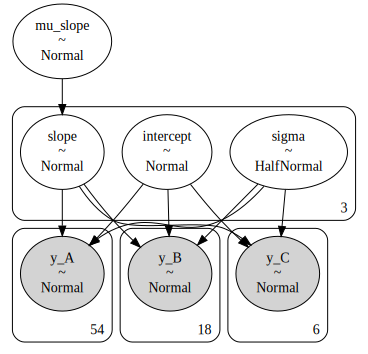

In [18]:
pm.model_to_graphviz(model_pp)

In [19]:
with model_pp:
    trace_pp = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, slope, intercept, mu_slope]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 22 seconds.
There were 262 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7172347830556864, but should be close to 0.8. Try to increase the number of tuning steps.
There were 275 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6588321465984094, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



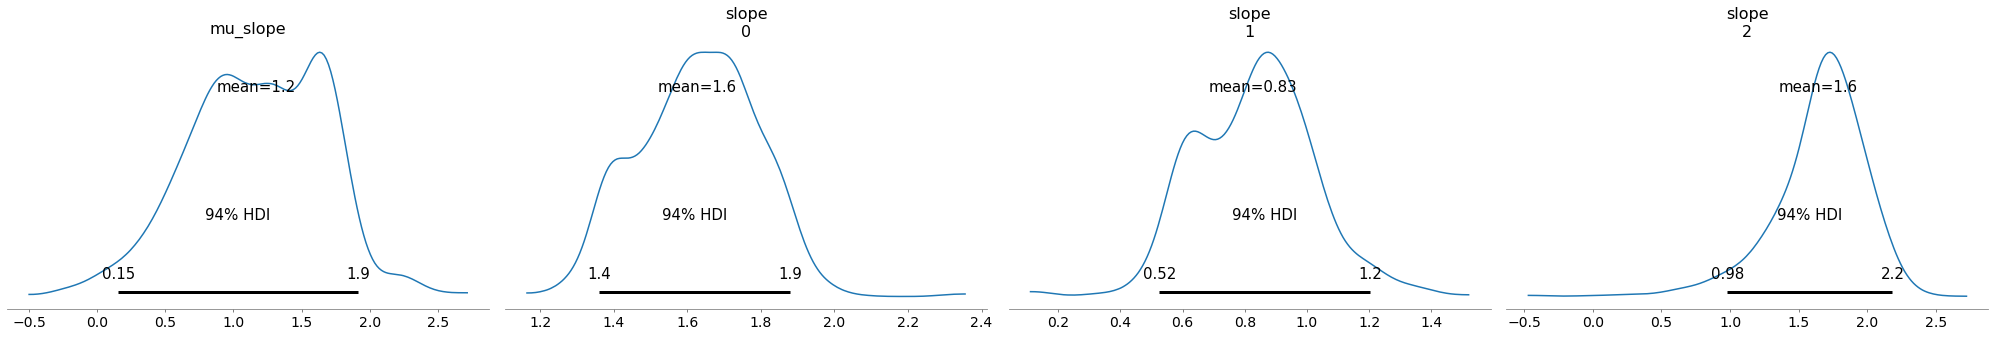

In [20]:
az.plot_posterior(trace_pp, var_names=['mu_slope', 'slope']);

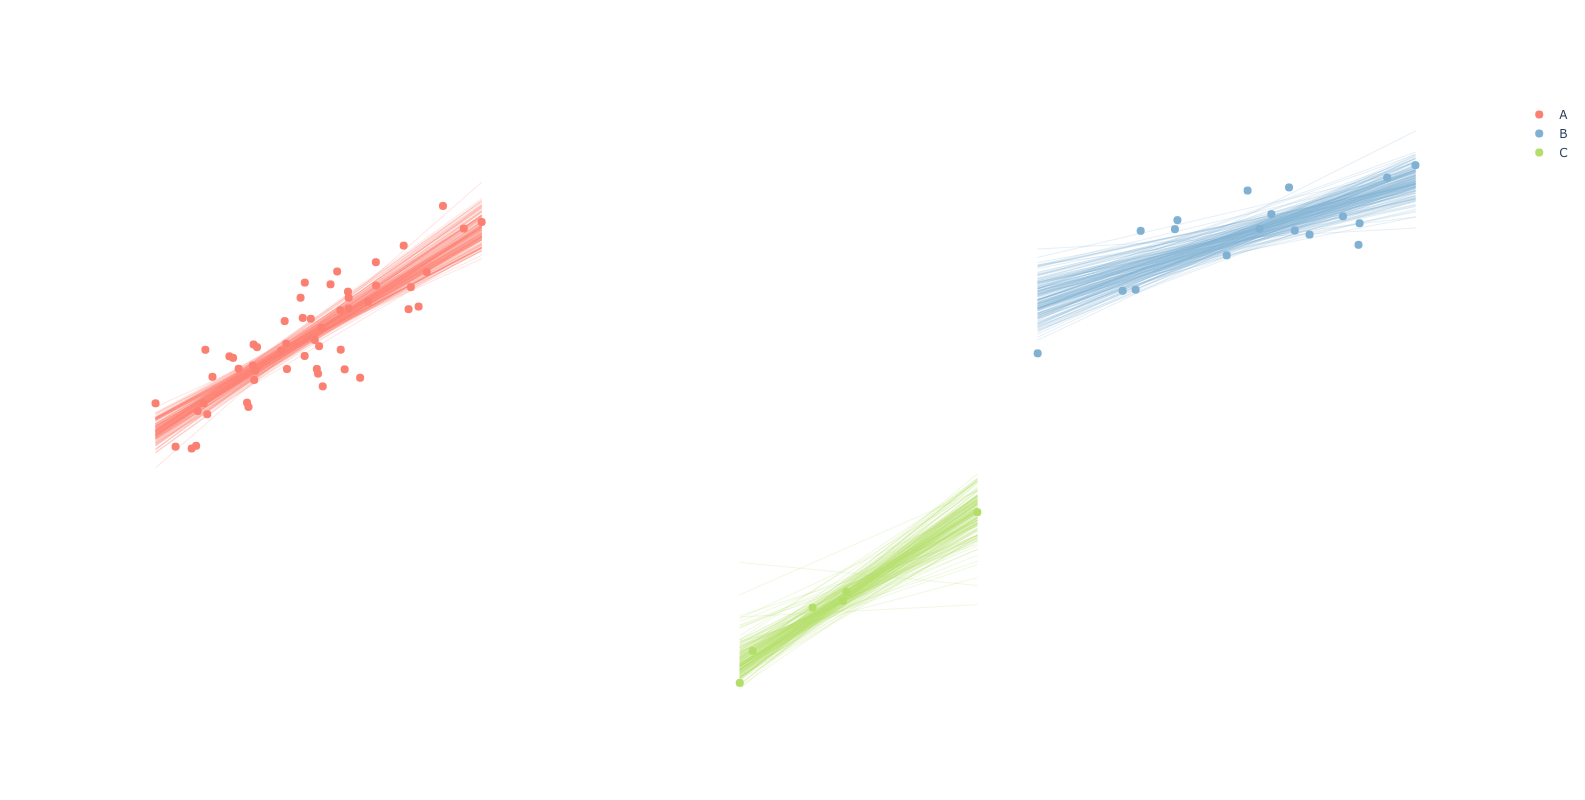

In [21]:
fig = figure(all_scatters(data, COLORS) + group_lines(trace_pp, data))
fig.show()

## Ask questions of the posterior

In [22]:
slope_c = trace_pp['slope'][:, 2]

In [23]:
slope_c[:10]

array([0.70376236, 0.6179819 , 0.61447999, 0.62742233, 0.84734131,
       1.12241751, 0.9516597 , 1.40990103, 1.37838527, 1.49158183])

In [24]:
(slope_c > 0.0).mean()

0.996

In [25]:
((slope_c > 1) & (slope_c < 1.5)).mean()

0.2015